# Proyek Klasifikasi Gambar: ANIMAL-10
- **Nama:** Rizki Surya Nugroho
- **Email:** nugrohorizki20@gmail.com
- **ID Dicoding:** MC223D5Y0760

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os, shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from google.colab import files
!pip install tensorflowjs

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rizkisuryanugroho","key":"62c19a01ee16998b95c411759aca5ad7"}'}

In [ ]:
os.makedirs("/root/.kaggle", exist_ok=True)

shutil.move("kaggle.json", "/root/.kaggle/kaggle.json")

os.chmod("/root/.kaggle/kaggle.json", 600)

In [ ]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0


In [ ]:
!unzip animals10.zip

Streaming output truncated to the last 5000 lines.
  inflating: raw-img/ragno/OIP-MVQChNQpHiMZEVMPehrvoAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-MVdIFDAFpNyK_XCpwkDIWgHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MYY_8k5AHqMJwTCNXfH6rwHaFj.jpeg  
  inflating: raw-img/ragno/OIP-MZEVXuoMsATG8u_UuTQ6hAHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MZg0tznDRE95AMfyuutuYAHaE6.jpeg  
  inflating: raw-img/ragno/OIP-M_r9DkR2X5gP0P5-z8wPYQHaE7.jpeg  
  inflating: raw-img/ragno/OIP-M_xDUSzjlF3-w9XHCm93cgHaFF.jpeg  
  inflating: raw-img/ragno/OIP-MbI4-bMyutRX3X382IAVcQAAAA.jpeg  
  inflating: raw-img/ragno/OIP-MbMksZdD7gomsC9fd6cpKgHaHJ.jpeg  
  inflating: raw-img/ragno/OIP-Md4AMcvjaHcivJqeW06wEwHaFW.jpeg  
  inflating: raw-img/ragno/OIP-MgCgailkT5XkO1XczzQCngHaLK.jpeg  
  inflating: raw-img/ragno/OIP-MgrKq05YHGXsgj1AmYIyJQHaE8.jpeg  
  inflating: raw-img/ragno/OIP-MhRGx7d8nbnHBuqrsO00EQHaFo.jpeg  
  inflating: raw-img/ragno/OIP-MiVgMXcKGQdog2KGe7i0YQHaHh.jpeg  
  inflating: raw-img/ragno/OIP-Mis0lJf3

#### Mengubah Bahasa Folder ke Bahasa Indonesia

In [ ]:
translate = {
    "cane": "anjing",
    "cavallo": "kuda",
    "elefante": "gajah",
    "farfalla": "kupu-kupu",
    "gallina": "ayam",
    "gatto": "kucing",
    "mucca": "sapi",
    "pecora": "domba",
    "ragno": "laba-laba",
    "scoiattolo": "tupai",
}

raw_img_dir = "/content/raw-img"

for folder_name in os.listdir(raw_img_dir):
  if folder_name in translate:
    new_folder_name = translate[folder_name]
    os.rename(os.path.join(raw_img_dir, folder_name), os.path.join(raw_img_dir, new_folder_name))


#### Menentukan Direktori untuk Dataset

In [ ]:
dataset_dir = "/content/raw-img"

#### Membuat Kamus untuk Menyimpan Gambar di Setiap Kelas

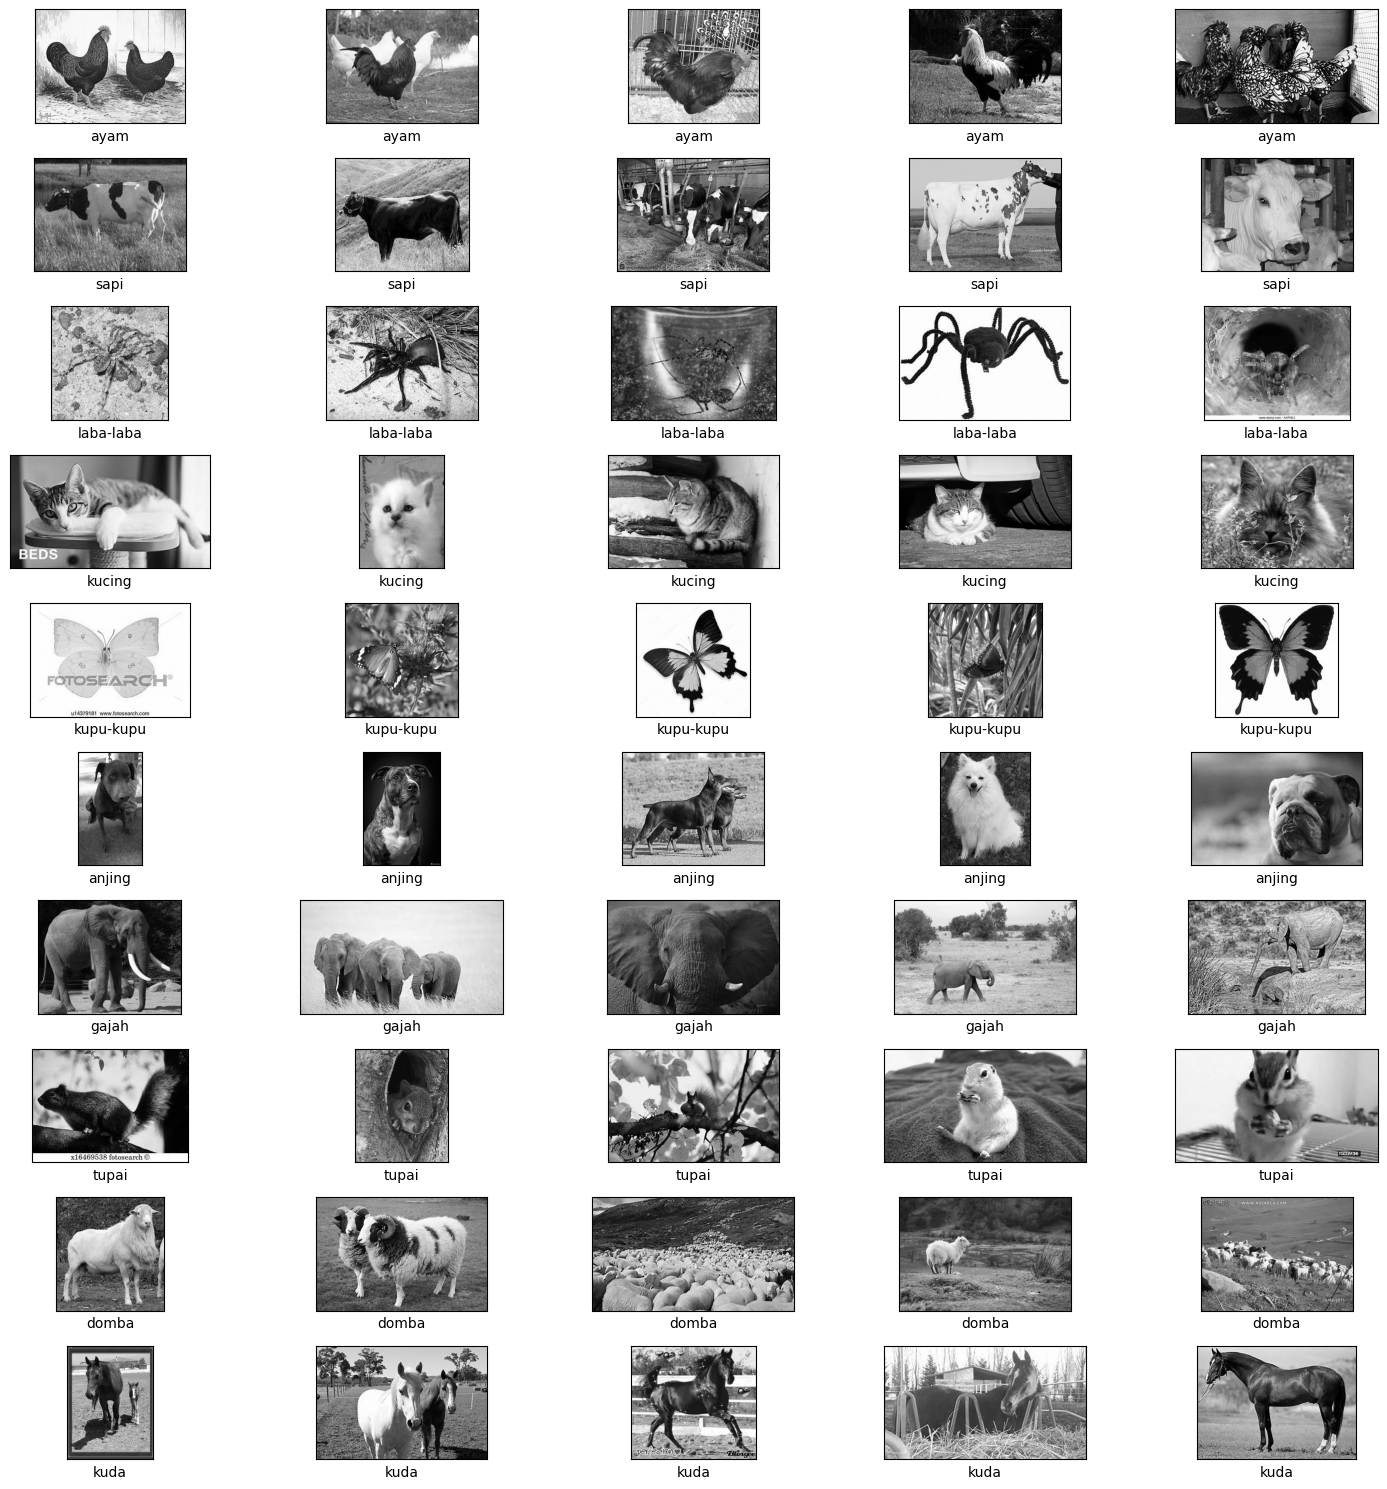

In [ ]:
animal_images = {}

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        animal_images[class_name] = os.listdir(class_path)

fig, axs = plt.subplots(len(animal_images.keys()), 5, figsize=(15, 15))
for i, class_name in enumerate(animal_images.keys()):
    if len(animal_images[class_name]) >= 5 :
        images = np.random.choice(animal_images[class_name], 5, replace=False)
        for j, image_name in enumerate(images):
            img_path = os.path.join(dataset_dir, class_name, image_name)
            try:
                img = Image.open(img_path).convert("L")
                axs[i, j].imshow(img, cmap='gray')
                axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    else:
        print(f"Class {class_name} has less than 5 images.")

fig.tight_layout()
plt.show()


#### Plot Distribusi Setiap Kelas

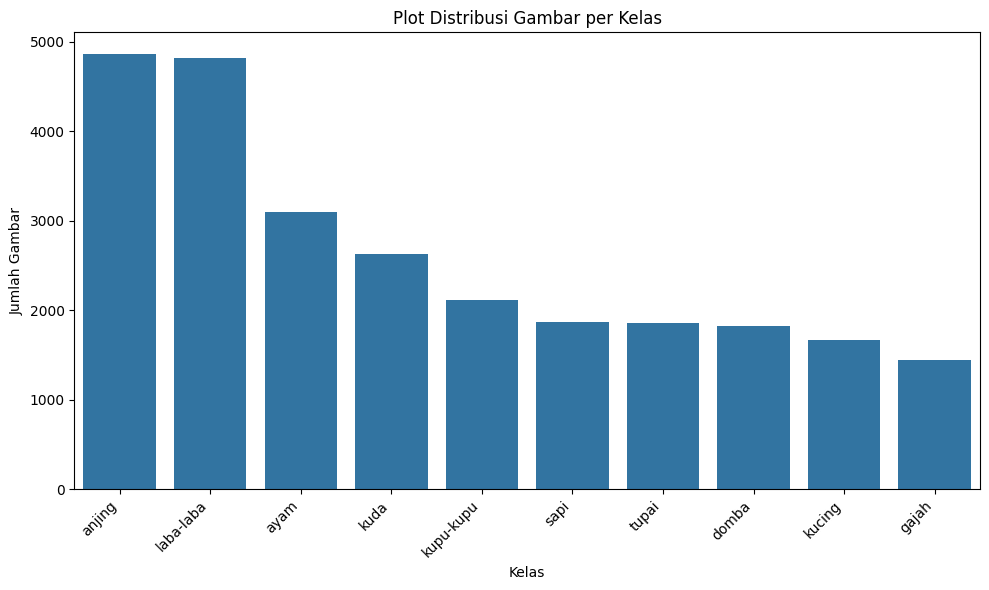

In [ ]:
class_counts = {class_name: len(images) for class_name, images in animal_images.items()}

sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(sorted_class_counts.keys()), y=list(sorted_class_counts.values()))
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.title("Plot Distribusi Gambar per Kelas")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Data Preprocessing

#### Split Dataset

In [ ]:
train_dir = "/content/data/train"
val_dir = "/content/data/val"
test_dir = "/content/data/test"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        images = os.listdir(class_path)

        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
        val_images, test_images = train_test_split(test_images, test_size=0.5, random_state=42)

        for image_name in train_images:
            shutil.copy(os.path.join(class_path, image_name), os.path.join(train_dir, class_name, image_name))

        for image_name in val_images:
            shutil.copy(os.path.join(class_path, image_name), os.path.join(val_dir, class_name, image_name))

        for image_name in test_images:
            shutil.copy(os.path.join(class_path, image_name), os.path.join(test_dir, class_name, image_name))

train_counts = {class_name: len(os.listdir(os.path.join(train_dir, class_name))) for class_name in os.listdir(train_dir)}
val_counts = {class_name: len(os.listdir(os.path.join(val_dir, class_name))) for class_name in os.listdir(val_dir)}
test_counts = {class_name: len(os.listdir(os.path.join(test_dir, class_name))) for class_name in os.listdir(test_dir)}

print(f"Train counts: {train_counts}")
print(f"Validation counts: {val_counts}")
print(f"Test counts: {test_counts}")


Train counts: {'ayam': 2478, 'sapi': 1492, 'laba-laba': 3856, 'kucing': 1334, 'kupu-kupu': 1689, 'anjing': 3890, 'gajah': 1156, 'tupai': 1489, 'domba': 1456, 'kuda': 2098}
Validation counts: {'ayam': 310, 'sapi': 187, 'laba-laba': 482, 'kucing': 167, 'kupu-kupu': 211, 'anjing': 486, 'gajah': 145, 'tupai': 186, 'domba': 182, 'kuda': 262}
Test counts: {'ayam': 310, 'sapi': 187, 'laba-laba': 483, 'kucing': 167, 'kupu-kupu': 212, 'anjing': 487, 'gajah': 145, 'tupai': 187, 'domba': 182, 'kuda': 263}


In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    fill_mode='nearest',
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=True,
    seed=1337
)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    'data/val',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=1337
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    'data/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=1337
)

Found 20938 images belonging to 10 classes.
Found 2618 images belonging to 10 classes.
Found 2623 images belonging to 10 classes.


## Modelling

#### Menggunakan Transfer Learning dari Mobile Net, dengan hanya mengambil feature extractornya saja dan tetap belajar dari model yang saya buat

In [ ]:
mobnet = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                              include_top=False,
                              weights='imagenet')
for layer in mobnet.layers:
    layer.trainable = False

In [ ]:
model = tf.keras.models.Sequential([
    mobnet,
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    factor=0.5,
    min_lr=0.00001
)

history = model.fit(
    train_generator,
    epochs=28,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_reduction]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 273s 401ms/step - accuracy: 0.7013 - loss: 0.9711 - val_accuracy: 0.8984 - val_loss: 0.3553 - learning_rate: 0.0010
Epoch 2/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 247s 377ms/step - accuracy: 0.8778 - loss: 0.4426 - val_accuracy: 0.9293 - val_loss: 0.2622 - learning_rate: 0.0010
Epoch 3/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 244s 372ms/step - accuracy: 0.8833 - loss: 0.4128 - val_accuracy: 0.9163 - val_loss: 0.3197 - learning_rate: 0.0010
Epoch 4/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 240s 367ms/step - accuracy: 0.9035 - loss: 0.3473 - val_accuracy: 0.9251 - val_loss: 0.2771 - learning_rate: 0.0010
Epoch 5/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9037 - loss: 0.3296
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
655/655 ━━━━━━━━━━━━━━━━━━━━ 240s 366ms/step - accuracy: 0.9037 - loss: 0.3296 - val_accuracy: 0.9248 - val_loss: 0.2727 - learning_rate: 0.0010
Epoch 6/28
655/655 ━━━━━━━━━━━━━━━━━━━━ 242s 370ms/step - accuracy:

## Evaluasi dan Visualisasi

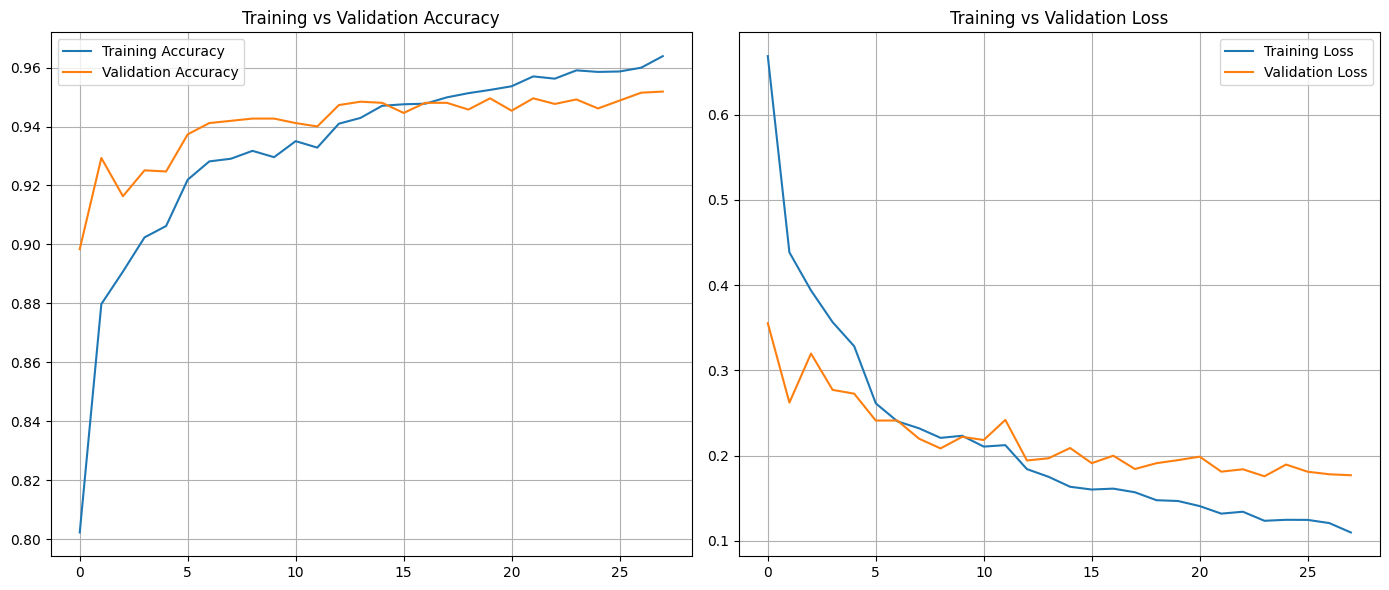

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9535 - loss: 0.1611

Test Accuracy: 0.9539
Test Loss: 0.1656


82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 108ms/step
📄 Classification Report:

              precision    recall  f1-score   support

      anjing       0.96      0.95      0.96       487
        ayam       0.97      0.96      0.96       310
       domba       0.92      0.92      0.92       182
       gajah       0.93      0.97      0.95       145
      kucing       0.96      0.96      0.96       167
        kuda       0.92      0.96      0.94       263
   kupu-kupu       0.92      0.97      0.94       212
   laba-laba       0.98      0.97      0.98       483
        sapi       0.94      0.89      0.92       187
       tupai       0.98      0.96      0.97       187

    accuracy                           0.95      2623
   macro avg       0.95      0.95      0.95      2623
weighted avg       0.95      0.95      0.95      2623



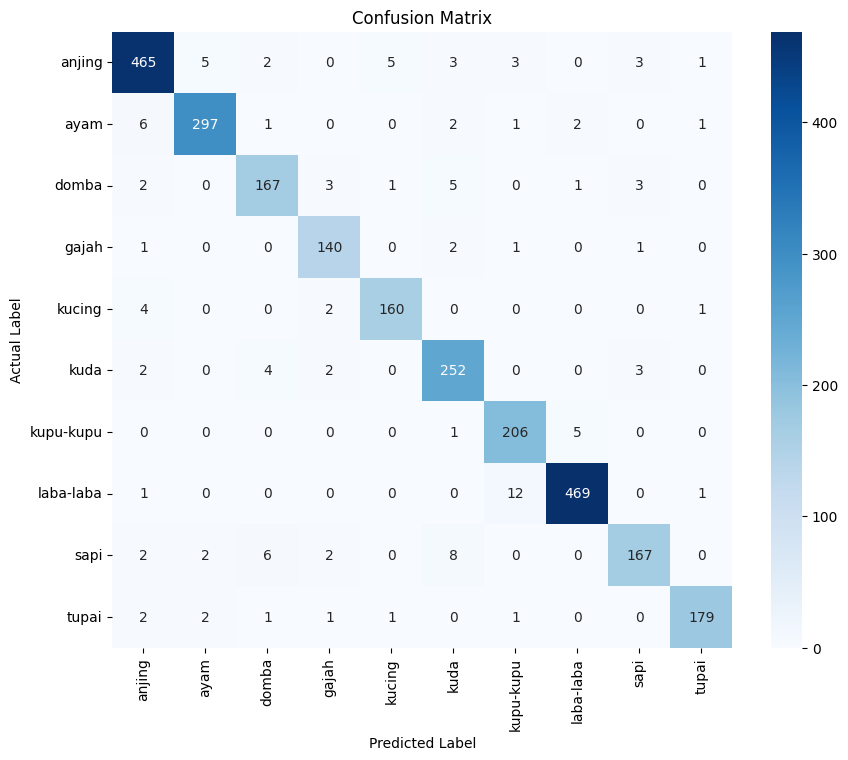

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print("📄 Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


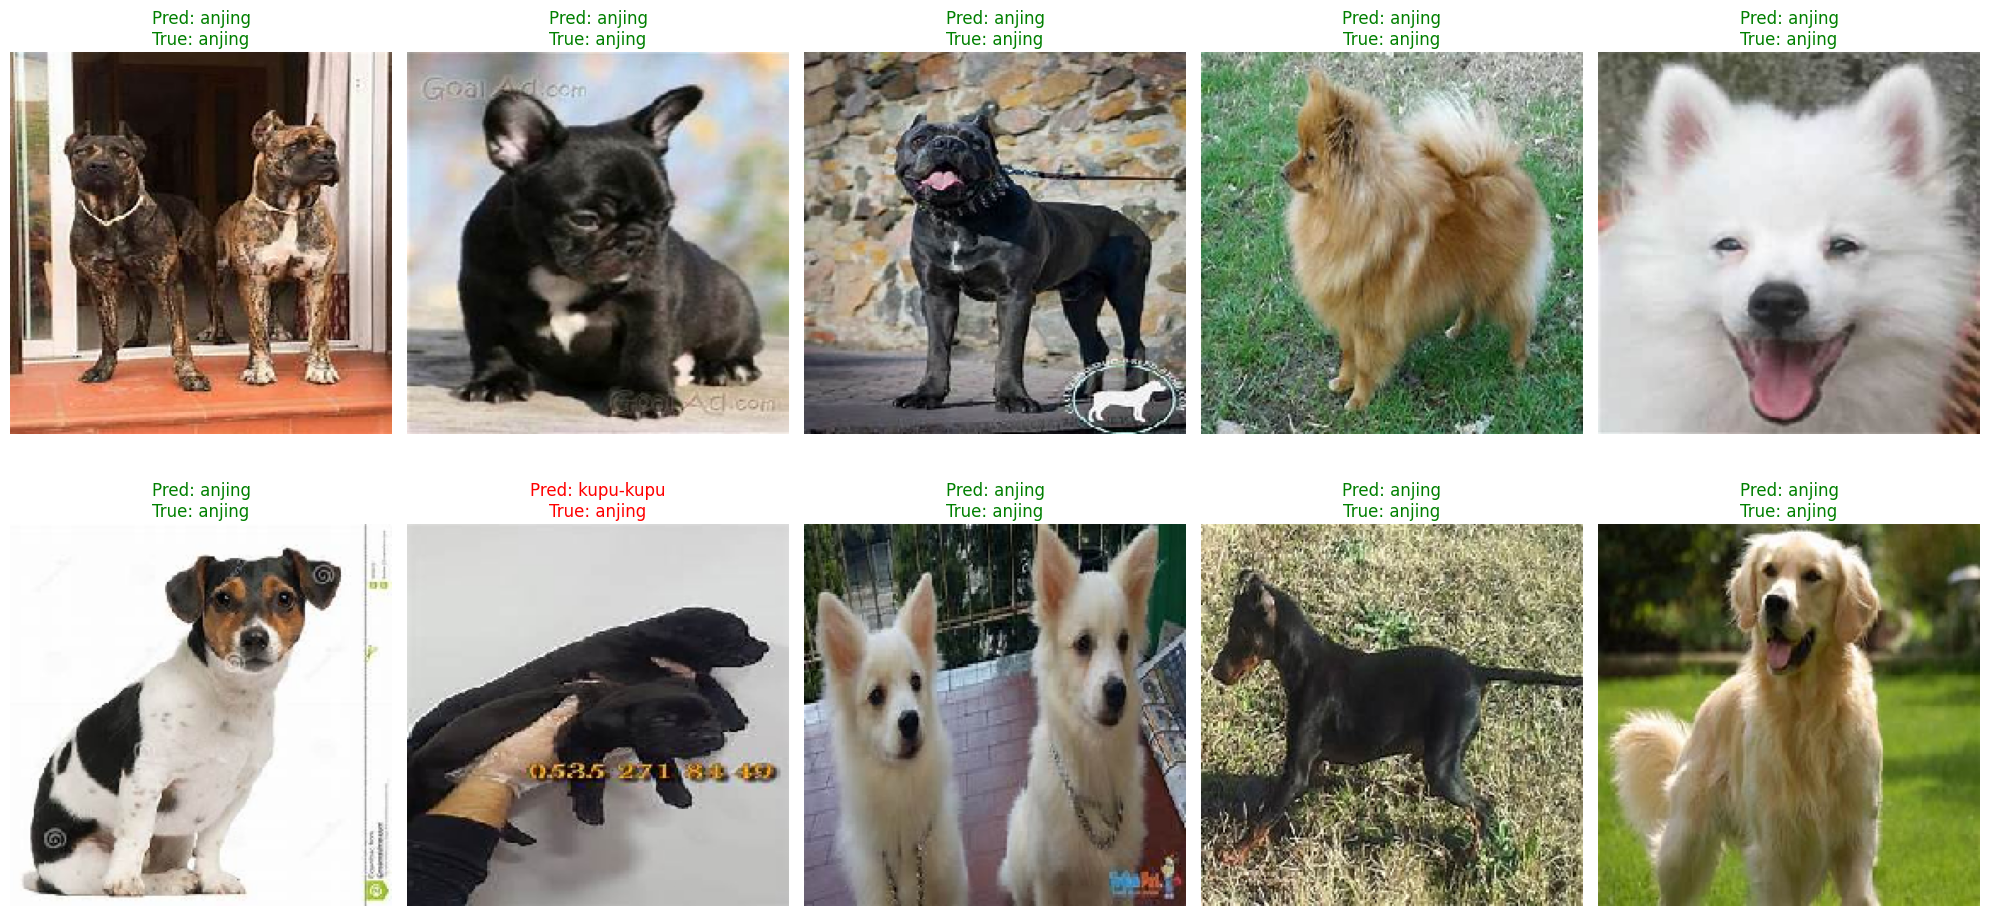

In [ ]:
test_generator.reset()

x_test, y_true = next(iter(test_generator))

y_pred = model.predict(x_test)
y_pred_labels = np.argmax(y_pred, axis=1)

label_map = {v: k for k, v in test_generator.class_indices.items()}

plt.figure(figsize=(20, 10))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_test[i])
    true_label = label_map[int(y_true[i])]
    pred_label = label_map[y_pred_labels[i]]
    color = "green" if y_pred_labels[i] == int(y_true[i]) else "red"
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
    plt.axis("off")
plt.tight_layout()
plt.show()

## Konversi Model

In [ ]:
model.export("saved_model")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_308')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  132595265149584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265151504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265151888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265151696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265150160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265153040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265153424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265153808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265153616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132595265150928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13259526515496

In [ ]:
os.makedirs("tflite", exist_ok=True)

converter = tf.lite.TFLiteConverter.from_saved_model("saved_model")
tflite_model = converter.convert()

with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

print("Model berhasil dikonversi ke TFLite")

Model berhasil dikonversi ke TFLite


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_node_names='StatefulPartitionedCall' \
    --saved_model_tags=serve \
    model_animal10 \
    tfjs_model

2025-04-24 03:34:45.716887: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745465685.785863   45711 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745465685.800953   45711 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-24 03:34:52.269743: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745465692.269913   45711 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

## Inference (Optional)

In [ ]:
def predict_image(img_path, model, class_indices):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_class_index = np.argmax(prediction)

    label_map = {v: k for k, v in class_indices.items()}
    predicted_class_label = label_map[predicted_class_index]
    confidence = prediction[0][predicted_class_index]

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Prediksi: {predicted_class_label}\nConfidence: {confidence:.2f}")
    plt.show()

    return predicted_class_label, confidence

In [ ]:
uploaded = files.upload()

Saving kucing_test.jpeg to kucing_test.jpeg


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


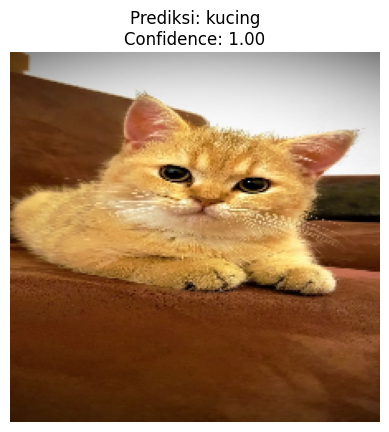

('kucing', np.float32(0.9984882))

In [ ]:
predict_image("kucing_test.jpeg", model, test_generator.class_indices)